In [4]:
import cv2 as cv
from os import path
import os
from glob import glob
from random import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import yaml

In [1]:
wsop_directory = "rank_suit_wsop" 
polygon_path = "polygons/"

In [2]:
def draw_polygon(img, polygon, gray=False):
    img_copy = img.copy()
    if gray:
        color = 255
    else:
        color = (255,0,0)
    if len(polygon) >= 3:
        pts = np.array(polygon, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv.polylines(img_copy, [pts], True, color, 4)
    return img_copy


def plot_images(images):
    sizes = [image.shape for image in images]
    w = np.max([size[1] for size in sizes])
    h = np.max([size[0] for size in sizes])
    fig, ax = plt.subplots(1, len(images), figsize=(3*len(images), 3), sharex=True, sharey=True)
    for i, image in enumerate(images):
        ax[i].imshow(image)
        ax[i].set_xlim(0, w)
        ax[i].set_ylim(0, h)
        ax[i].invert_yaxis()
        #ax[i].axis('off')
    plt.show()

# function for creating two corners of a rectangle based on mask
def get_corners(mask):
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    # get the coordinates of the pixels in the mask
    coords = np.argwhere(mask)
    # get the bounding box of those pixels
    y_min = np.min(coords[:,0])
    y_max = np.max(coords[:,0])
    x_min = np.min(coords[:,1])
    x_max = np.max(coords[:,1])
    return (x_min, y_min), (x_max, y_max)

In [3]:
# Define a function to handle mouse events
def draw_polygon_call(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        param['points'].append((x, y))
    elif event == cv.EVENT_RBUTTONDOWN:
        param['points'] = []

# Function to interactively draw a polygon on an image
def set_polygon(img, points = []):
    # Define the points that make up the polygon
    param = {}
    param['points'] = points
    
    # Set the mouse callback function
    cv.namedWindow("Polygon")
    cv.setMouseCallback("Polygon", draw_polygon_call, param)

    # Draw the polygon interactively on the image
    while True:
        # Make a copy of the image to draw on
        polygon_img = draw_polygon(img, param['points'])

        # Display the result
        cv.imshow("Polygon", polygon_img)

        # Wait for a key press
        key = cv.waitKey(1) & 0xFF

        # Exit if the 'q' key is pressed
        if key == ord("q"):
            break

    # Close all windows
    cv.destroyAllWindows()
    return param['points'], polygon_img

In [5]:
# get files in the directory
files = os.listdir(wsop_directory)

images = [cv.imread(path.join(wsop_directory, file)) for file in files]

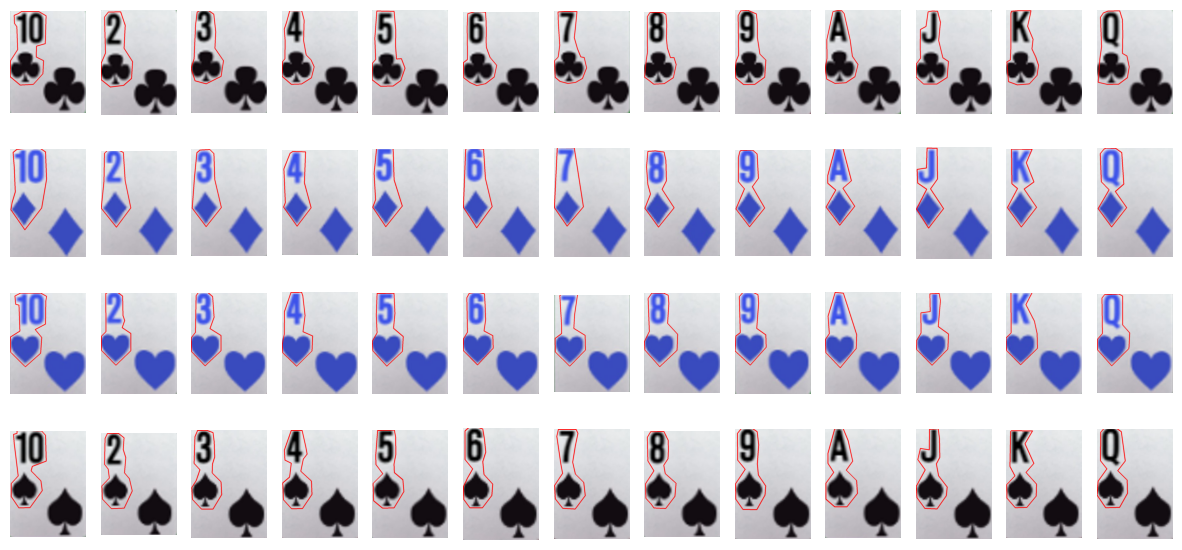

In [7]:

polygons = []
if not os.path.exists(polygon_path):    
    os.makedirs(polygon_path)
for i in range(len(images)):
    poly_path = os.path.join(polygon_path, files[i].split(".")[0] + ".npy")
    points = []
    if os.path.exists(poly_path):
        points = list(np.load(poly_path))       

    points, polygon_img = set_polygon(images[i], points=points)
    #save points
    np.save(poly_path, points)
    polygons.append(points)

plt.figure(figsize=(15, 7))
for i in range(13):
    for j in range(4):
        img = images[i + j*13]
        polygon = polygons[i + j*13]
        img_copy = draw_polygon(img, polygon, gray=False)

        plt.subplot(4, 13, i + j*13 + 1)
        plt.imshow(img_copy)
        plt.axis('off')